# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

### Ratings file

Each line contains a rated movie:
- a user
- an item
- a rating from 1 to 5 stars

In [ ]:
import pandas as pd

raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released. The movies file contains columns indicating the movie's genres. Let's only load the first five columns of the file with `usecols`.

In [ ]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


Let's write a bit of Python preprocessing code to extract the release year as an integer value:

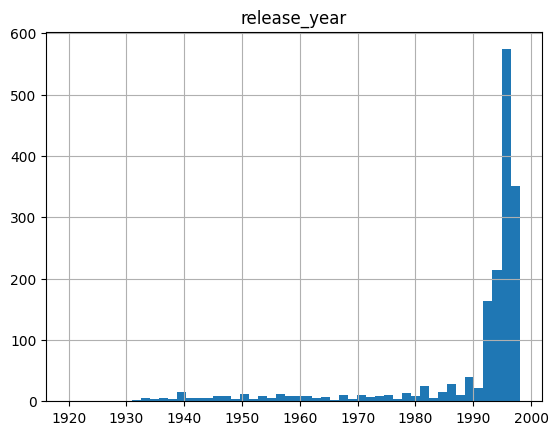

In [ ]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50);

Enrich the raw ratings data with the collected items metadata:

In [ ]:
all_ratings = pd.merge(items, raw_ratings)

In [ ]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution
- the popularity of each movie

In [ ]:
min_user_id = all_ratings['user_id'].min()
min_user_id

1

In [ ]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [ ]:
min_item_id = all_ratings['item_id'].min()
min_item_id

1

In [ ]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [ ]:
all_ratings['rating'].describe()

,rating
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Let's do a bit more pandas magic compute the popularity of each movie (number of ratings):

In [ ]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)

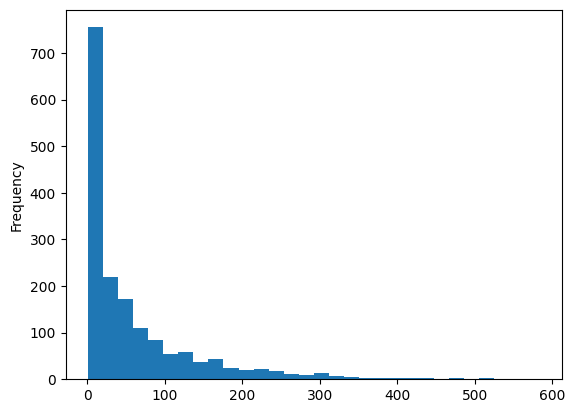

In [ ]:
items['popularity'].plot.hist(bins=30);

In [ ]:
(items['popularity'] == 1).sum()

np.int64(141)

In [ ]:
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [ ]:
items["title"][181]

'GoodFellas (1990)'

In [ ]:
items["title"].loc[181]

'GoodFellas (1990)'

In [ ]:
items["title"].iloc[181]

'GoodFellas (1990)'

In [ ]:
indexed_items = items.set_index('item_id')
indexed_items.nlargest(10, 'popularity')

,popularity,title,release_date,video_release_date,imdb_url,release_year
item_id,,,,,,
50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997


In [ ]:
indexed_items["title"][181]

'Return of the Jedi (1983)'

In [ ]:
indexed_items["title"].loc[181]

'Return of the Jedi (1983)'

In [ ]:
indexed_items["title"].iloc[181]

'GoodFellas (1990)'

In [ ]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,0.0,100000.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,NaN,1987.950100,462.48475,3.529860,8.835289e+08
std,330.798356,121.784558,NaN,14.169558,266.61442,1.125674,5.343856e+06
min,1.000000,1.000000,NaN,1920.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,NaN,1998.000000,943.00000,5.000000,8.932866e+08


In [ ]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


Later in the analysis we will assume that this popularity does not come from the ratings themselves but from an external metadata, e.g. box office numbers in the month after the release in movie theaters.

Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [ ]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal.

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="images/rec_archi_1.svg" style="width: 600px;" />

In [ ]:
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Model

In [ ]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer="adam", loss='mae')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [ ]:
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


(80000, 1)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitly. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute model errors on the training set
mae = mean_absolute_error(rating_train, initial_train_preds)
mse = mean_squared_error(rating_train, initial_train_preds)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Absolute Error (MAE): 3.5286
Mean Squared Error (MSE): 13.7197


### Monitoring runs

Keras enables to monitor various variables during training.

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [ ]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2996 - val_loss: 1.0332
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9015 - val_loss: 0.7898
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7536 - val_loss: 0.7679
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7311 - val_loss: 0.7579
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7148 - val_loss: 0.7547
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6979 - val_loss: 0.7473
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6699 - val_loss: 0.7380
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6569 - val_loss: 0.7424
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6278 - val_loss: 0.7384
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6070 - val_loss: 0.7392
CPU times: user 38.3 s, sys: 2.79 s, total: 41.1 s
Wall time: 35 s


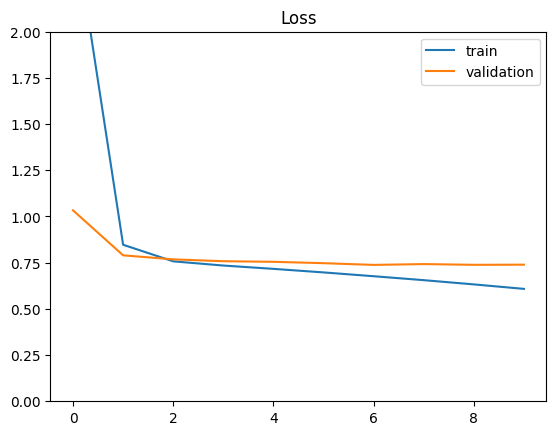

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Why is the train loss higher than the first loss in the first few epochs?
- Why is Keras not computing the train loss on the full training set at the end of each epoch as it does on the validation set?


Now that the model is trained, the model MSE and MAE look nicer:

In [ ]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final test MSE: 0.903
Final test MAE: 0.732


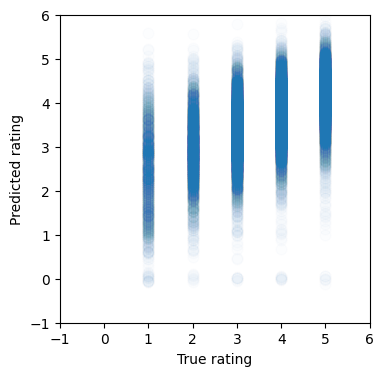

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Final train MSE: 0.641
Final train MAE: 0.588


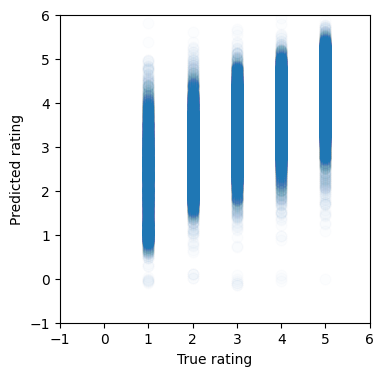

In [ ]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))
plot_predictions(rating_train, train_preds)

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [ ]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [ ]:
# Solution:
# model.summary()

In [ ]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [ ]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [ ]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[-0.41134673 -0.2222221   0.36143523 -0.5948105  -0.22657244  0.4094412
  0.3283015   0.34289876  0.18776359  0.42183056 -0.08448575 -0.27554202
  0.59316295  0.19848123 -0.35206538 -0.307368    0.06634583  0.15739815
  0.36053076  0.41423512 -0.3899478  -0.42173892 -0.10801879 -0.17899595
  0.30041978 -0.35023642 -0.39279878 -0.16252491 -0.12917936  0.02491358
 -0.34467056  0.22217448  0.38552698 -0.35490003  0.42700252  0.352065
 -0.47744197 -0.10863384  0.25961092 -0.44240516  0.40228453 -0.28861552
  0.30487725 -0.3045599  -0.10935985 -0.05413045  0.21229182  0.404623
 -0.29458436 -0.43017712  0.42429286  0.29706842  0.3696494   0.06627662
  0.06541603  0.3394032   0.38562146 -0.03507506  0.4501059   0.19165178
 -0.15539677 -0.20325378 -0.45689747 -0.52604884]
shape: (64,)


### Finding most similar items

Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space.
- Test it on the following cells to check the similarities between popular movies.
- Bonus: try to generalize the function to compute the similarities between one movie and all the others and return the most related movies.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [ ]:
EPSILON = 1e-07  # to avoid division by zero

def cosine(x, y):
    """
    Compute cosine similarity between two vectors x and y.
    Cosine similarity = (x · y) / (||x|| * ||y||)
    """
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    similarity = dot_product / (norm_x * norm_y + EPSILON)
    return similarity


In [ ]:
# Verify your answer from a tutor.


In [ ]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")

print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.923


In [ ]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.807


In [ ]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.878


In [ ]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


In [ ]:
def cosine_similarities(item_id, item_embeddings):
    """Compute similarities between item_id and all items embeddings"""
    query_vector = item_embeddings[item_id]
    dot_products = item_embeddings @ query_vector

    query_vector_norm = np.linalg.norm(query_vector)
    all_item_norms = np.linalg.norm(item_embeddings, axis=1)
    norm_products = query_vector_norm * all_item_norms
    return dot_products / (norm_products + EPSILON)


similarities = cosine_similarities(181, item_embeddings)
similarities

array([0.2049516 , 0.87753946, 0.76810175, ..., 0.7536993 , 0.8042461 ,
       0.71658146], dtype=float32)

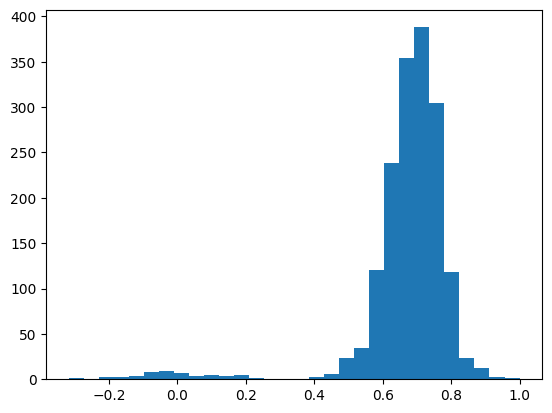

In [ ]:
plt.hist(similarities, bins=30);

In [ ]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    sims = cosine_similarities(item_id, item_embeddings)
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))


most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(np.int64(50), 'Star Wars (1977)', np.float32(1.0000001)),
 (np.int64(181), 'Return of the Jedi (1983)', np.float32(0.92277205)),
 (np.int64(172), 'Empire Strikes Back, The (1980)', np.float32(0.9004661)),
 (np.int64(1), 'Toy Story (1995)', np.float32(0.8839149)),
 (np.int64(183), 'Alien (1979)', np.float32(0.8838721)),
 (np.int64(318), "Schindler's List (1993)", np.float32(0.88305753)),
 (np.int64(430), 'Duck Soup (1933)', np.float32(0.8816061)),
 (np.int64(257), 'Men in Black (1997)', np.float32(0.879694)),
 (np.int64(195), 'Terminator, The (1984)', np.float32(0.87833184)),
 (np.int64(173), 'Princess Bride, The (1987)', np.float32(0.8731621))]

In [ ]:
items[items['title'].str.contains("Star Trek")]

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
221,222,365,Star Trek: First Contact (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1996
226,227,161,Star Trek VI: The Undiscovered Country (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1991
227,228,244,Star Trek: The Wrath of Khan (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1982
228,229,171,Star Trek III: The Search for Spock (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1984
229,230,199,Star Trek IV: The Voyage Home (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1986
379,380,116,Star Trek: Generations (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1994
448,449,117,Star Trek: The Motion Picture (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1979
449,450,63,Star Trek V: The Final Frontier (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1989


In [ ]:
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(np.int64(227),
  'Star Trek VI: The Undiscovered Country (1991)',
  np.float32(0.99999994)),
 (np.int64(228),
  'Star Trek: The Wrath of Khan (1982)',
  np.float32(0.90946364)),
 (np.int64(230),
  'Star Trek IV: The Voyage Home (1986)',
  np.float32(0.90859735)),
 (np.int64(222), 'Star Trek: First Contact (1996)', np.float32(0.8736906)),
 (np.int64(195), 'Terminator, The (1984)', np.float32(0.8703542)),
 (np.int64(755), 'Jumanji (1995)', np.float32(0.86994267)),
 (np.int64(229),
  'Star Trek III: The Search for Spock (1984)',
  np.float32(0.868602)),
 (np.int64(890), 'Mortal Kombat: Annihilation (1997)', np.float32(0.86642456)),
 (np.int64(82), 'Jurassic Park (1993)', np.float32(0.86414045)),
 (np.int64(109),
  'Mystery Science Theater 3000: The Movie (1996)',
  np.float32(0.86339647))]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [ ]:
from sklearn.manifold import TSNE

item_tsne = TSNE(learning_rate="auto", init="pca", perplexity=30).fit_transform(item_embeddings)

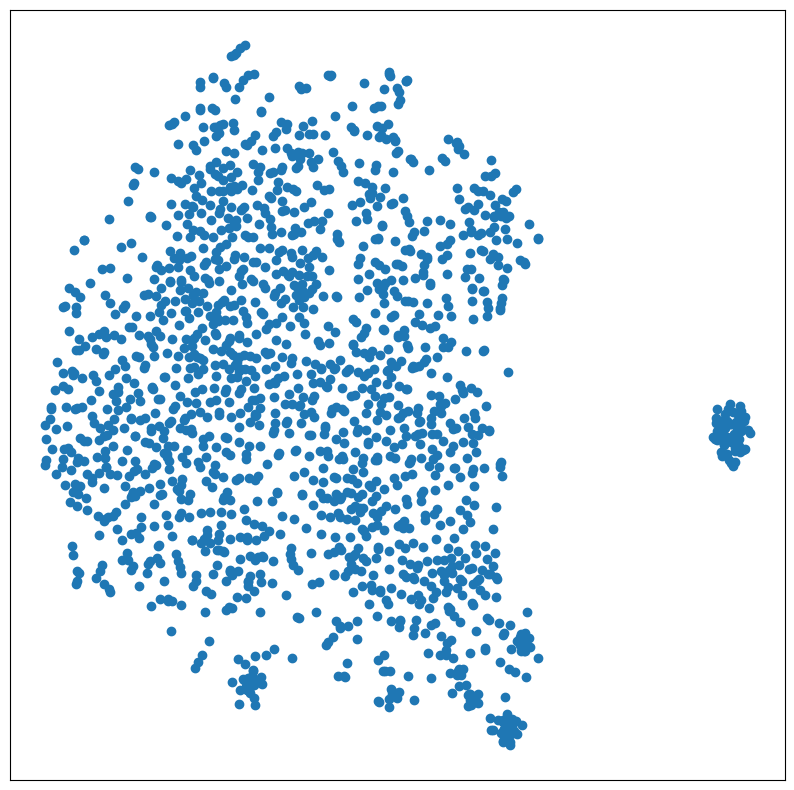

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1])
plt.xticks(()); plt.yticks(())
plt.show()

In [ ]:
# %pip install -q plotly

In [ ]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title", "popularity"])

Alternatively with [Uniform Manifold Approximation and Projection](https://github.com/lmcinnes/umap):

In [ ]:
# %pip install umap-learn

In [ ]:
# import umap

# item_umap = umap.UMAP().fit_transform(item_embeddings)
# plt.figure(figsize=(10, 10))
# plt.scatter(item_umap[:, 0], item_umap[:, 1]);
# plt.xticks(()); plt.yticks(());
# plt.show()

## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="images/rec_archi_2.svg" style="width: 600px;" />

To build this model we will need a new kind of layer:

In [ ]:
from keras.layers import Concatenate


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

In [ ]:
from keras.layers import Embedding, Flatten, Dense, Dropout, Concatenate
from keras.models import Model

class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        self.flatten = Flatten()
        self.concat = Concatenate()

        # Dropout less aggressive
        self.dropout = Dropout(0.3)
        self.dense1 = Dense(64, activation="relu")
        self.dense2 = Dense(1, activation="linear")  # single numeric output

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dense2(y)
        return y


model = DeepRegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='mae')  # mean absolute error

# Verify with predictions
initial_train_preds = model.predict([user_id_train, item_id_train])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
# Verify your answer from a tutor.

In [ ]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4417 - val_loss: 0.7607
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7504 - val_loss: 0.7495
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7364 - val_loss: 0.7453
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7188 - val_loss: 0.7340
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7125 - val_loss: 0.7306
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7021 - val_loss: 0.7295
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6950 - val_loss: 0.7309
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6912 - val_loss: 0.7288
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6899 - val_loss: 0.7272
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6820 - val_loss: 0.7272
CPU times: user 45.6 s, sys: 3.07 s, total: 48.7 s
Wall time: 36.8 s


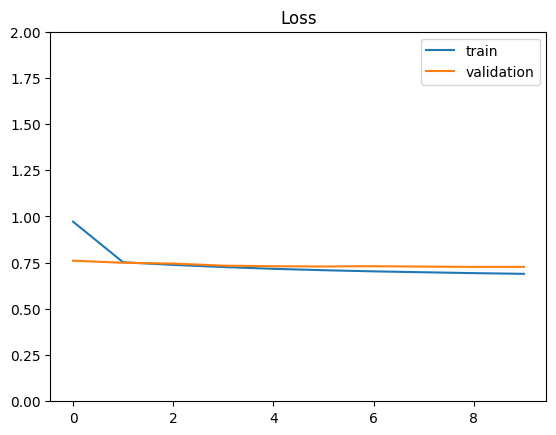

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [ ]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Final train MSE: 0.803
Final train MAE: 0.666


In [ ]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final test MSE: 0.908
Final test MAE: 0.726


The performance of this model is not necessarily significantly better than the previous model but you can notice that the gap between train and test is lower, probably thanks to the use of dropout.

Furthermore this model is more flexible in the sense that we can extend it to include metadata for hybrid recsys as we will see in the following.

### Home assignment:
 - Add another layer, compare train/test error.
 - Can you improve the test MAE?
 - Try adding more dropout and change layer sizes.


Manual tuning of so many hyperparameters is tedious. In practice it's better to automate the design of the model using an hyperparameter search tool such as:

- https://keras-team.github.io/keras-tuner/ (Keras specific)
- https://optuna.org/ (any machine learning framework, Keras included)

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [ ]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [ ]:
class HybridModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        self.dense1 = Dense(64, activation="relu")
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        meta_inputs = inputs[2]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        user_vecs = self.dropout(user_vecs, training=training)

        item_vecs = self.flatten(self.item_embedding(item_inputs))
        item_vecs = self.dropout(item_vecs, training=training)

        input_vecs = self.concat([user_vecs, item_vecs, meta_inputs])

        y = self.dense1(input_vecs)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)
        y = self.dense3(y)
        return y

model = HybridModel(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train,
                                     item_id_train,
                                     item_meta_train])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train],
                    rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3267 - val_loss: 0.7671
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8454 - val_loss: 0.7637
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.8123 - val_loss: 0.7384
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7865 - val_loss: 0.7370
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7708 - val_loss: 0.7457
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7537 - val_loss: 0.7335
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7409 - val_loss: 0.7276
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.7335 - val_loss: 0.7305
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7165 - val_loss: 0.7296
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7114 - val_loss: 0.7270
CPU times: user 51.7 s, sys: 3.24 s, total: 54.9 s
Wall time: 44.2 s


In [ ]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final test MSE: 0.870
Final test MAE: 0.727


The additional metadata seems to improve the predictive power of the model a bit but this should be re-run several times to see the impact of the random initialization of the model.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [ ]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))

    item_ids = np.array(item_ids)
    user_ids = np.zeros_like(item_ids)
    user_ids[:] = user_id
    items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])

    rating_preds = model.predict([user_ids, item_ids, items_meta])

    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["title"][movie], rating_preds[movie][0])
            for movie in rec_items]

In [ ]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

User 5 has seen 175 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Return of the Jedi (1983)
    Toy Story (1995)
    Independence Day (ID4) (1996)
    Raiders of the Lost Ark (1981)
    Silence of the Lambs, The (1991)
    Empire Strikes Back, The (1980)
    Star Trek: First Contact (1996)
    Back to the Future (1985)
    Mission: Impossible (1996)
    Fugitive, The (1993)
    Indiana Jones and the Last Crusade (1989)
    Willy Wonka and the Chocolate Factory (1971)
    Princess Bride, The (1987)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Men in Black (1997)
    E.T. the Extra-Terrestrial (1982)
    Birdcage, The (1996)
Computing ratings for 1506 other movies:
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
    4.5: August (1996)
    4.5: Raising Arizona (1987)
    4.4: Robocop 3 (1993)
    4.4: Richard III (1995)
    4.4: Madness of King George, The (1994)
    4.4: Boys of St. Vincent, The (1993)
    4.4: Romy and Michele's High School Reunion (1997)

### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [ ]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5])

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

In [ ]:
# Verify your answer from a tutor.